First, import libraries needed to run this notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns


Have a glance of the list of files stored in a folder

In [2]:
os.listdir('trial/')

['.idea',
 '.ipynb_checkpoints',
 '10001.mat.zip',
 '10003.mat.zip',
 'fMRI_mask.nii',
 'fnc.csv',
 'ICN_numbers.csv',
 'loading.csv',
 'reveal_ID_site2.csv',
 'sample_submission.csv',
 'train_scores.csv',
 'trends_neuroimaging-master']

Read into the data files

In [3]:
train_scores = pd.read_csv("trial/train_scores.csv")
fnc = pd.read_csv("trial/fnc.csv")
loading = pd.read_csv("trial/loading.csv")
icn_no = pd.read_csv("trial/ICN_numbers.csv")
id_site2 = pd.read_csv("trial/reveal_ID_site2.csv")
submission = pd.read_csv("trial/sample_submission.csv")


### Visualising target distributions

Text(0.5, 0.98, 'Target Viz')

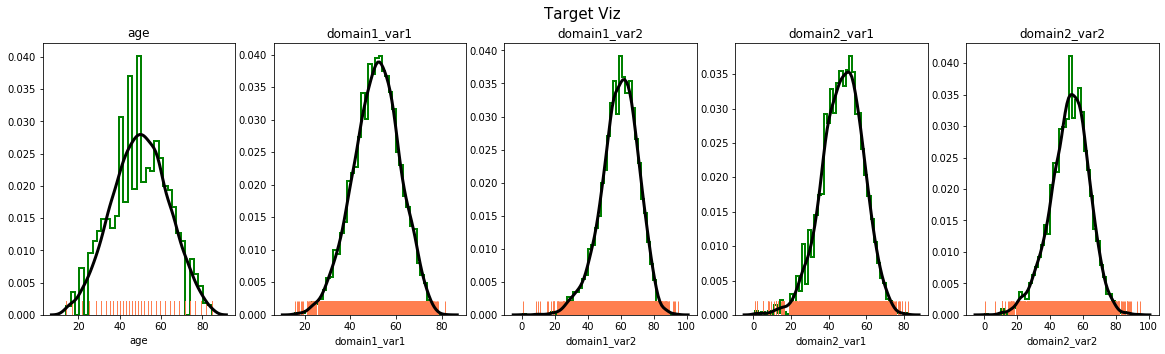

In [4]:
def dist_plot(var, i, rug_color, kde_color, hist_color, title):
    import seaborn as sns
    sns.distplot(var, rug=True, ax=ax[i], rug_kws={"color": rug_color},
            kde_kws={"color": kde_color, "lw": 3}, 
            hist_kws={"histtype": "step", "linewidth": 2, 
                     "alpha": 1, "color": hist_color}).set_title(title)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

rug_color = "coral"
kde_color = "black"
hist_color = "g"

for i in range(0, len(ax)):
    dist_plot(train_scores.iloc[:, i+1], i, rug_color, kde_color, hist_color, train_scores.columns[i+1])
   # ax.set_yticks([])
   # ax.spines['left'].set_visible(False)

fig.suptitle('Target Viz', fontsize=15)

#### Just keeping a note of the no. of columns/variables in each file
length of train_scores.columns (inclu. id): 6  
length of loading.columns (inclu. id) : 27  
length of fnc.columns (inclu. id) : 1379


#### Dealing with missing data
There are missing values in the 'train_scores.csv' file (i.e. in some of the 'domain_' variables). 
Depending on your strategy, the missing data need to be treated. Here, we just substitute the missing data with mean values

In [5]:
#train_scores.isnull().sum()
train_scores.fillna(train_scores.mean(),inplace=True)

Now, combine and restrict to only train_data (the 'train_scores.csv' file contains only ID for 'train' cases)

In [6]:
#There are a lot of features in the fnc file. 'Rescale' them to prevent potential overfitting
FNC_SCALE = 1/500
fnc_features = fnc.columns[1:]
fnc[fnc_features] *= FNC_SCALE


train_data = train_scores.merge(loading, on='Id', how='left')
train_data = train_data.merge(fnc, on='Id', how='left')
train_data.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,-0.000299,0.001106,0.000262,0.000671,0.000790,-0.000086,0.000249,-0.000121,0.001032,0.000581
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.000428,-0.000080,0.000286,-0.000380,0.000997,0.000888,0.001185,0.000057,0.001411,0.000497
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-0.000261,0.000619,0.000283,0.000062,0.000689,0.000428,0.000635,0.000025,0.001332,0.000163
3,10005,66.532630,51.474692,59.244132,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,-0.000279,0.000790,0.000081,0.000857,0.000998,0.000534,0.000455,0.000058,0.001505,0.000176
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,-0.000300,0.000818,0.000144,0.000315,0.001064,0.000711,0.000925,0.000322,0.001407,0.000587


### Exploring 'feature' data in the train set

#### SBM loadings

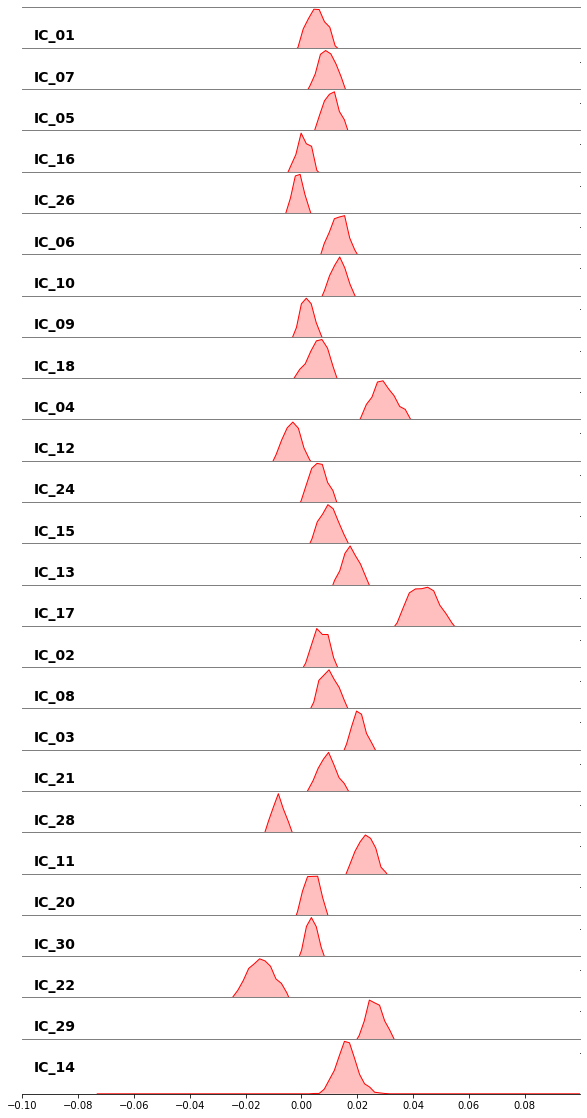

In [7]:
#create a ridgeline plot to visualise the SBM variables

def ax_settings(ax, var_name, x_min, x_max):
    ax.set_xlim(x_min,x_max)
    ax.set_yticks([])
    ax.set_xticks([])

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_edgecolor('gray')
    ax.spines['top'].set_linewidth('1')
    
    ax.text(0.02, 0.4, var_name, fontsize=14, fontweight="bold", transform = ax.transAxes) 
    return None

n_feature = len(loading.columns) -1   # 26 = no. of features from SBM; and starting from coln 5 in train_data 

fig, ax = plt.subplots(ncols=1, nrows=n_feature, figsize=(10, 20)) #, sharex=True, sharey=True)

for i in range(0, len(ax)):
    sns.kdeplot(data=train_data.iloc[:,i+6], ax=ax[i], shade=True, color="red",  
                lw=1, bw=0.025, legend=False)
    #x_min = train_data.iloc[:,i+6].min() + (train_data.iloc[:,i+6].min())*2
    #x_max = train_data.iloc[:,i+6].max()*2
    ax_settings(ax[i], train_data.columns[i+6], -0.1, 0.1)    

ax[25].set_xticks(np.arange(-0.1, 0.1, step=0.02))

#make the subplot overlaps with each other...
fig.subplots_adjust(hspace=-.25)



With SBM loadings, there are relatively few features still. We can examine the correlation between target variables and features.


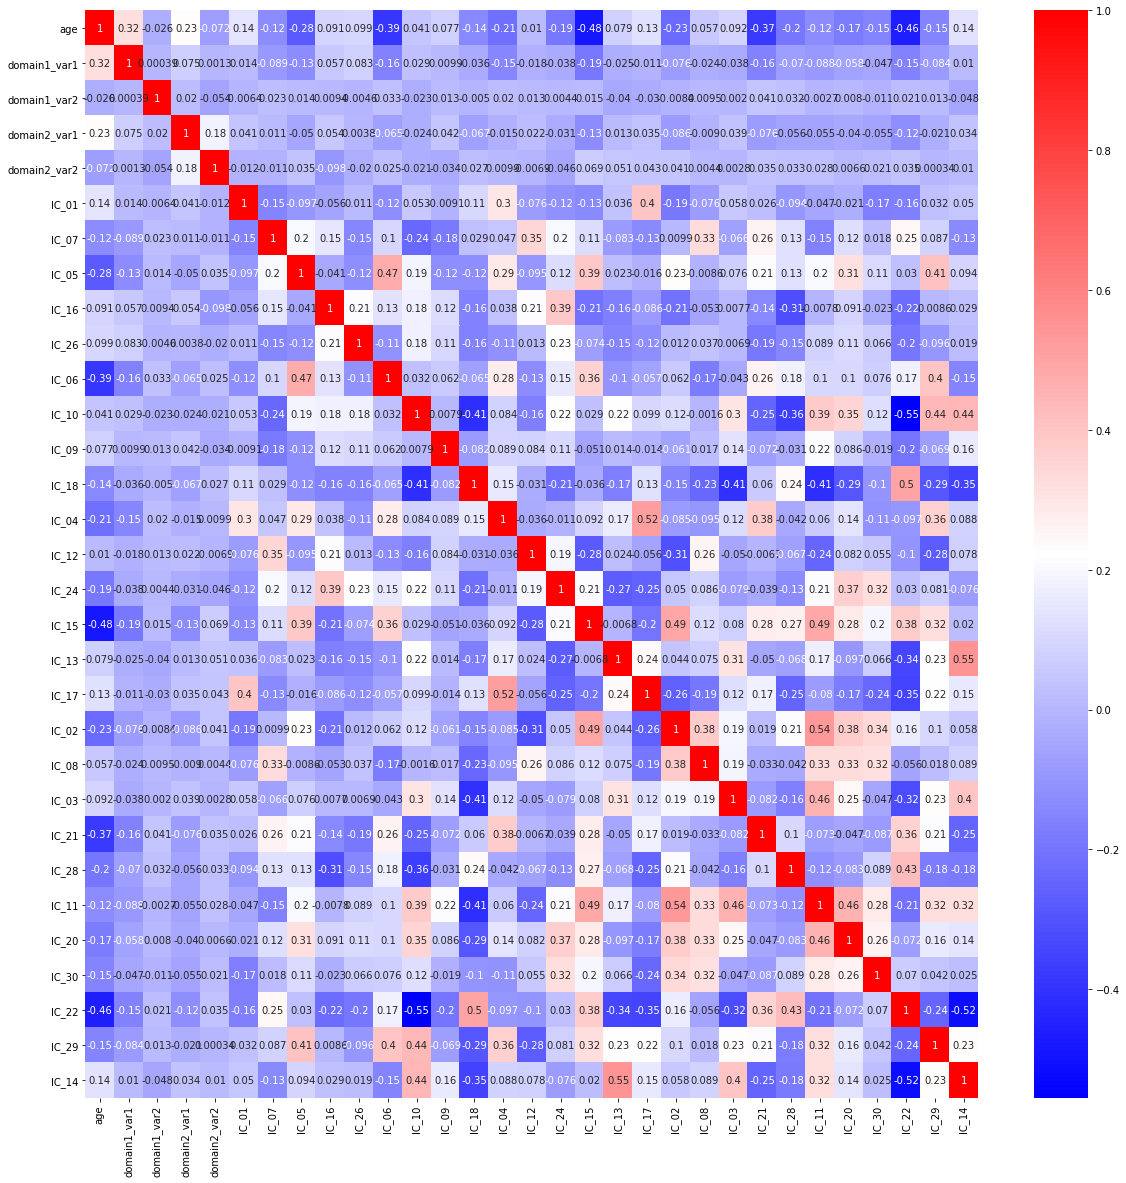

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
cols = train_data.columns[1:32]
sns.heatmap(train_data[cols].corr(), annot=True, cmap='bwr', ax=ax)


#### Split data into X_train, y_train for train data, and only X_test for test set

In [9]:
features = ('age', 'domain1_var1', 'domain1_var2','domain2_var1','domain2_var2')

#prepare the train data (X_train: features; y_train: outcomes)
X_train = train_data.drop(list(features), axis=1).drop('Id', axis=1)
y_train = train_data[list(features)]

# prepare the test data
# Here, the 'fnc' features have already been 'rescaled' with a multiplication of 1/500
Id_no = submission['Id'].apply(lambda x: int(x.split('_')[0])).unique()
test = pd.DataFrame({'Id' : Id_no})
test_pred_df = test.copy()
#submission.head()
test_data = test.merge(loading, on='Id', how='left')
test_data = test_data.merge(fnc, on='Id', how='left')

X_test = test_data.drop('Id', axis=1)




#### More model testing will be incorporated here

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

model = RandomForestRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5
)

cv = KFold(n_splits = 5, shuffle=True, random_state=29)
grid = {
    'n_estimators':[5,10]  #20,100
}
gs = GridSearchCV(model, grid, n_jobs=-1, cv=cv, verbose=5, scoring='neg_mean_absolute_error')

In [11]:
best_models = {}
for col in features:
    gs.fit(X_train, y_train[col])   
    best_models[col] = gs.best_estimator_  
    print(gs.best_score_)
    

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.2min remaining:   48.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


-8.504526167234783
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.3min remaining:   50.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


-7.704440350416414
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.4min remaining:   56.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


-8.55417238731387
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.4min remaining:   55.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


-8.927599987542862
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.4min remaining:   54.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


-9.401936730317285


In [12]:
best_models

{'age': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'domain1_var1': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, v

#### Evaluation metrics to assess the performances of the models for this challenge

In [13]:
def eval_metric(y_true, y_pred):
    return (np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))


In [14]:
features = ('age', 'domain1_var1', 'domain1_var2','domain2_var1','domain2_var2')
weights = (.3, .175, .175, .175, .175)

overall_score=0

for col, weight in zip(features, weights):
    y_pred_train = best_models[col].predict(X_train)
    score = eval_metric(y_train[col], y_pred_train)
    overall_score += score*weight

    print("{}: {}".format(col,score))
print("Overall-score: {}".format(overall_score))

age: 0.10106594819442005
domain1_var1: 0.10105023371866706
domain1_var2: 0.11796909943720062
domain2_var1: 0.14181025027420924
domain2_var2: 0.13462435679927778
Overall-score: 0.11702422399846307


### Preparing the 'test' predicted outcomes in the format required for submission

In [15]:
for col in features:
    test_pred_df[col] = best_models[col].predict(X_test)


In [17]:
submit_df = pd.melt(test_pred_df, id_vars=["Id"], value_name='Predicted')
submit_df["Id"]=submit_df["Id"].astype("str") + "_" + submit_df["variable"].astype("str")

submit_df = submit_df.drop("variable", axis=1).sort_values("Id")

#check if the submit_df has the correct number of entries
if not submit_df.shape[0] == test_pred_df.shape[0]*5:
    raise AssertionError()


In [18]:
submit_df

,Id,Predicted
0,10003_age,48.629853
5877,10003_domain1_var1,48.669418
11754,10003_domain1_var2,60.327876
17631,10003_domain2_var1,46.132939
23508,10003_domain2_var2,58.961293
...,...,...
5876,21753_age,35.764386
11753,21753_domain1_var1,52.896083
17630,21753_domain1_var2,61.058480
23507,21753_domain2_var1,45.977537
